In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

In [2]:
import sys
sys.path.append("../code")
import model
import plotting

## Parameters

In [4]:
y0 = {
    'S': 276618.,
    'V': 599864.,
    'W':  97500.,
    'E':    390.,
    'EB':    39.,
    'I':    974.,
    'IB':    97.,
    'ICU':   18.,
    'R':  24500.,
    'UC':650000.,
    'WC':  5000.,
}

params = {
    'y0': list(y0.values()),
    'Rt_base': 3.5,
    'Rt_free': 5.0,
    'eta': 0.8,
    'kappa': 0.95,
    'sigma': 0.5,
    'gamma': 0.1,
    'gamma_ICU': 0.13,
    'delta': 0.0019,
    'rho': 0.25,
    'omega_v_b': 1./(6*30),
    'omega_n_b': 1./(12*30),
    'chi_0': 0.1,
    'chi_1': 0.2,
    'alpha_w': 0.008,
    'alpha_u': 0.01,
    'alpha_R': 0.008,
    'e_R': 0.,
    'e_u': 0.,
    'e_w': 0.,
    'Phi_0': 0.0025,
    'phi_0': 0.0025,
    'u_base': 0.5,
    'mu': 0.267,
    'd_0': 8*30.,
    'd_mu': 0.,
    'a_Rt': 4.,
    'a_vac': 14.,
    'gamma_cutoff': 30.,
    'tau_vac1': 6*7.,
    'tau_vac2': 2*7.,
    't_max': 360.,
    'step_size': 0.1,
}

## Model

In [6]:
m = model.Model(**params)

In [20]:
sweep = np.arange(0.,0.021,0.001)
results = []

In [21]:
for a in sweep:
    m.alpha_R = a
    times, data = m.run()
    results.append(m.data)

In [17]:
m_plot = model.Model(**params)
m_plot.times = m.times

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


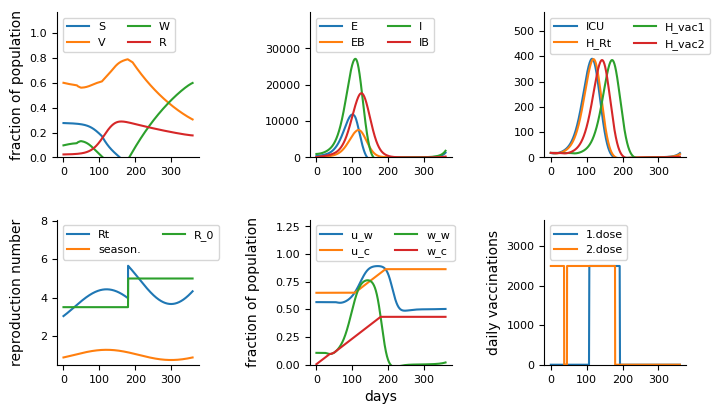

In [18]:
m_plot.alpha_R = sweep[0]
m_plot.data = results[0]
plotting.overview(m_plot)

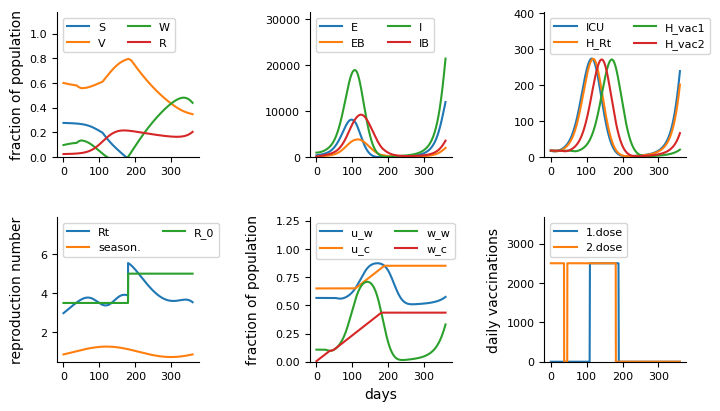

In [19]:
m_plot.alpha_R = sweep[1]
m_plot.data = results[1]
plotting.overview(m_plot)

In [23]:
1e-5 1e-1
alpha_R = 0.008 = 8e-3

21

<Figure size 300x200 with 0 Axes>

<Figure size 300x200 with 0 Axes>

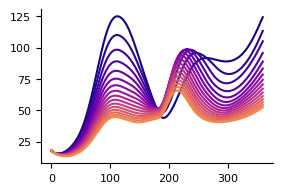

In [67]:
fig = plt.figure(figsize=(3, 2))
t = m.times
for i in range(21-5):
    m_plot.alpha_R = sweep[i+5]
    m_plot.data = results[i+5]
    plt.plot(t, m_plot.chopped_data()[:,7], color=plt.cm.plasma(i/21.))

#plt.colorbar()
plt.show()

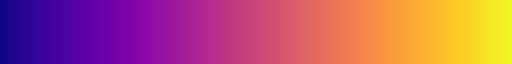

In [56]:
plt.cm.plasma